# Examples of the BioSCRAPE package
## Biocircuit Stochastic Simulation of Single Cell Reactions and Parameter Estimation

The purpose of this Python notebook is twofold. 

1. The first is to serve as a quick start guide where you should be able to get started with the package by simply looking at the examples here and copying them to your liking. 

2. The second is as a unit testing replacement. It is hard to unit test stochastic algorithms as the output may not (and should not) be the same thing every time. Therefore, instead, if all the examples included below work well, then you can assume that the package installed correctly and is working fine.

Before, getting started, we start by doing some basic plotting configuration and importing the numpy library. Advanced users can modify this to their liking.

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

#%config InlineBackend.figure_f.ormats=['svg']

mpl.rc('axes', prop_cycle=(mpl.cycler('color', ['r', 'k', 'b','g','y','m','c']) ))

mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12)


import numpy as np


# 1. A Simple Model of Gene Expression

We start with a simple model of gene expression that only contains 4 reactions: transcription, translation, mRNA degradation, and protein degradation. The rate of transcription is constant, and the rates of translation, mRNA degradation, and protein degradation are linear in mRNA, protein, and protein respectively. This model is included in models/gene_expression_with_delay.xml, where you can look at it. The model text is included below as well.

    <model>
    <reaction text="--" after="--mRNA">
        <propensity type="massaction" k="beta" species="" />
        <delay type="fixed" delay="tx_delay" />
    </reaction>

    <reaction text="mRNA--" after="--">
        <propensity type="massaction" k="delta_m" species="mRNA" />
        <delay type="none" />
    </reaction>

    <reaction text="--" after="--protein">
        <propensity type="massaction" k="k_tl" species="mRNA" />
        <delay type="gamma" k="tx_k" theta="tx_theta" />
    </reaction>

    <reaction text="protein--">
        <propensity type="massaction" k="delta_p" species="protein" />
        <delay type="none" />
    </reaction>


    <parameter name="beta" value="2.0" />
    <parameter name="delta_m" value="0.2" />
    <parameter name="k_tl" value="5.0" />
    <parameter name="delta_p" value="0.05" />
    <parameter name="tx_delay" value="10" />
    <parameter name="tl_delay" value="10" />
    <parameter name="tx_k" value="2" />
    <parameter name="tx_theta" value="5" />

    <species name="mRNA" value="0" />
    <species name="protein" value="0" />
    </model>
    
From this code, you can see that there are 4 reactions. Each reaction specifies a text field which says what reactants go to what products. The after field specifies the delayed part of the reaction. Each reaction has a propensity and a delay. At the bottom, all the parameter values and initial species values are specified.

Simulating this model with a regular DeterministicSimulator or a regular SSASimulator will result in the specified delays being ignored and assumed to be zero. In order for the delay to matter, you must do a simulation with a stochastic delay simulator.

Let's start by trying out the model without delay in both the deterministic and stochastic case.

## 1a. Simple Model of Gene Expression without Delay

Below, we load in the simple model of gene expression. We then simulate it determinstically and stochastically. The parameters have been chosen so that the mean mRNA level should be 10 and the mean protein level should be 1000.

Thus, the deterministic simulation should quickly go to a steady state of mRNA = 10 and protein = 1000 and the stochastic simulation should bounce around that number.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Depricated Warning: Bioscrape XML is being replaced by SBML and will no longer be supported in a future version of the software.
  if sys.path[0] == '':


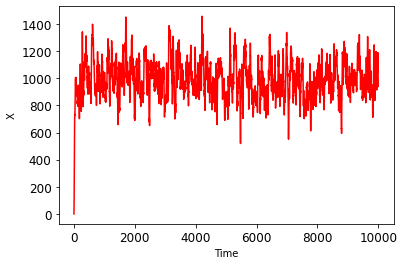

In [6]:
# Code for simple gene expression without delay

# Import relevant types
from bioscrape.types import Model
from bioscrape.simulator import DeterministicSimulator, SSASimulator
from bioscrape.simulator import ModelCSimInterface, SafeModelCSimInterface
import numpy as np
import pylab as plt
import time as pytime

# Load the model by creating a model with the file name containing the model
m = Model('models/gene_expression_with_delay.xml', input_printout = False)

# Expose the model's core characteristics for simulation. (i.e. stoichiometry,
# delays, and propensities)

s = ModelCSimInterface(m)
# This function uses sparsity to further optimize the speed of deterministic
# simulations. You must call it before doing deterministic simulations.
s.py_prep_deterministic_simulation()

# Set up our desired timepoints for which to simulate. 
# Must match with initial time.
timepoints = np.linspace(0,10000,10000)

# Create a DeterministicSimulator as well as an SSASimulator

ssa_simulator = SSASimulator()
det_simulator = DeterministicSimulator()

# Set the initial simulation time
s.py_set_initial_time(0)

# This function uses sparsity to further optimize the speed of deterministic
# simulations. You must call it before doing deterministic simulations.
s.py_prep_deterministic_simulation()

# Simulate the model with both simulators for the desired timepoints
stoch_result = ssa_simulator.py_simulate(s,timepoints)
det_result = det_simulator.py_simulate(s,timepoints)


# Process the simulation output.

# py_get_result() returns a numpy 2d array of timepoints x species.
# Each row is one time point and each column is a species.
stoch_sim_output = stoch_result.py_get_result()

# Get the indices for each species of interest

# From the model, we can recover which column corresponds to which species, so
# we then know which column of the result array is which species.
X_ind = m.get_species_index('X')

# Plot the mRNA levels over time for both deterministic and stochastic simulation

plt.plot(timepoints,stoch_sim_output[:,X_ind])
plt.xlabel('Time')
plt.ylabel('X')
plt.show()

### Results

In the above plots, ideally you see for mRNA a smooth line going to a steady state of 10 with another line from the stochastic simulation bouncing around.

For the protein, you should see something similar but with the value being 1000 at steady state.

## 1b. Simulate Gene Expression Model with Delay

We can now try and simulate the model from before that we've already loaded while accounting for delays. This time, we will use a delay SSA simulator. From the model, there are only delays for transcription and translation. The transcription delay was specified as

    <delay type="fixed" delay="tx_delay" />
    
In this term, the delay is of a fixed type meaning it's always a constant, and the length of the delay is given in the parameter tx_delay.

The translation delay is specified as

    <delay type="gamma" k="tx_k" theta="tx_theta" />

In this term, the delay is specified by a gamma distribution, which means the delay time for this reaction to happen is a gamma random variable with parameters $k$ and $\theta$, where those parameters are specified by tx_k and tx_theta.

In addition to specifying the delays, we also need a DelayQueue in order to do delay simulations. The delay queue is a data structure that keeps track of what future reactions have been queued up to occur. Different implementations of the DelayQueue used can have severe tradeoffs in speed and accuracy.

    

Text(0, 0.5, 'Protein')

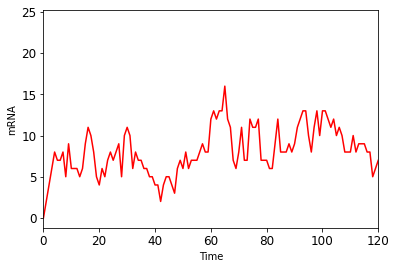

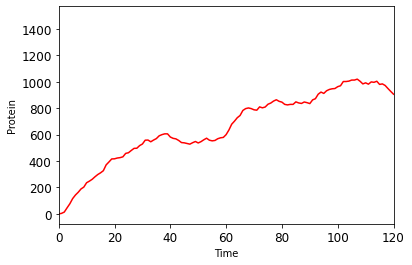

In [7]:
# Simulate the simple gene expression model WITH delay.

# import a couple of additional types that we need
from bioscrape.simulator import ArrayDelayQueue
from bioscrape.simulator import DelaySSASimulator

# Create a delay queue with setup_queue(num_reactions, num_timepoints, dt)
# so this delay queue will go up to 1500 * 0.01 = 15 time units in the future.
# You want to pick the delay queue resolution to be small for accuracy, and then
# have enough time points to capture the maximum length delay that could possibly
# occur.
q = ArrayDelayQueue.setup_queue(4,1500,0.01)

# Like before when we created an SSA simulator, now we create a DelaySSASimulator
delay_simulator = DelaySSASimulator()

# Simulate just like before, but now we need to pass the DelayQueue q as an
# extra argument. The delayqueue is part of the initial state as well, as any
# reactions already on the queue will occur.
# In this case, however, the queue is empty to begin with.
answer = delay_simulator.py_delay_simulate(s,q,timepoints)

# Recover the state trajctory from the simulation.
state = answer.py_get_result()
mrna_ind = m.get_species_index('mRNA')
prot_ind = m.get_species_index('protein')

# Plot the mRNA
plt.plot(timepoints,state[:,mrna_ind])
plt.xlim((0,120))
plt.xlabel('Time')
plt.ylabel('mRNA')

# Plot the Protein
plt.figure()
plt.plot(timepoints,state[:,prot_ind])
plt.xlim((0,120))
plt.xlabel('Time')
plt.ylabel('Protein')

### Results

In this case, the results should be a delay of 10 before transcription begins and then a final mRNA level of around 10, as well as a delay of about 20 before protein appears with a final protein level of around 1000. The translation delay is gamma distributed, so the protein turns on somewhat smoothly, while the mRNA transcription delay is fixed at 10 minutes, so the mRNA turns on sharply.


# SBML Compatibility

The next cell imports a model from an SBML file and then simulates it using a deterministic simulation. There are limitations to SBML compatibility.

1. Cannot support delays or events when reading in SBML files. Events will be ignored and a warning will be printed out.
2. SBML reaction rates must be in a format such that when the reaction rates are converted to a string formula, sympy must be able to parse the formula. This will work fine for usual PEMDAS rates. This will fail for complex function definitions and things like that.
3. Species will be initialized to their initialAmount field when it is nonzero. If the initialAmount is zero, then the initialConcentration will be used instead.
4. Multiple compartments or anything related to having compartments will not be supported. No warnings will be provided for this.
5. Assignment rules are supported, but any other type of rule will be ignored and an associated warning will be printed out.
6. Parameter names must start with a letter and be alphanumeric, same for species names. Furthermore, log, exp, abs, heaviside, and other associated keywords for functions are not allowed to be variable names. When in doubt, just pick something else :)

Below, we first plot out the simulation results for an SBML model where a species X0 goes to a final species X1 through an enymatic process.

C:\ProgramData\Anaconda3\lib\site-packages\bioscrape\sbmlutil.py:228: UserWarning: Compartments, UnitDefintions, Events, and some other SBML model components are not recognized by bioscrape. Refer to the bioscrape wiki for more information.
  warnings.warn('Compartments, UnitDefintions, Events, and some other SBML model components are not recognized by bioscrape. ' +


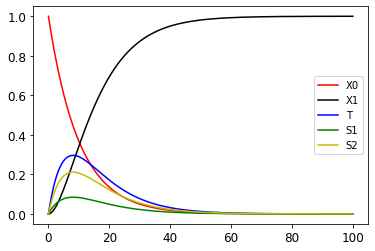

In [8]:
import bioscrape
m = bioscrape.sbmlutil.import_sbml('models/sbml_test.xml')
s = bioscrape.simulator.ModelCSimInterface(m)
s.py_prep_deterministic_simulation()
s.py_set_initial_time(0)

sim = bioscrape.simulator.DeterministicSimulator()
timepoints = np.linspace(0,100,1000)
result = sim.py_simulate(s,timepoints)
plt.plot(timepoints,result.py_get_result())

plt.legend(m.get_species_list())

## Deterministic and Stochastic Simulation of the Repressilator

We  plot out the repressilator model found <a href="http://www.ebi.ac.uk/biomodels-main/BIOMD0000000012">here</a>. This model generates oscillations as expected. Highlighting the utility of this package, we then with a single line of code switch to a stochastic simulation and note that the amplitudes of each burst become noisy.

C:\ProgramData\Anaconda3\lib\site-packages\bioscrape\sbmlutil.py:228: UserWarning: Compartments, UnitDefintions, Events, and some other SBML model components are not recognized by bioscrape. Refer to the bioscrape wiki for more information.
  warnings.warn('Compartments, UnitDefintions, Events, and some other SBML model components are not recognized by bioscrape. ' +


Text(0, 0.5, 'Amount')

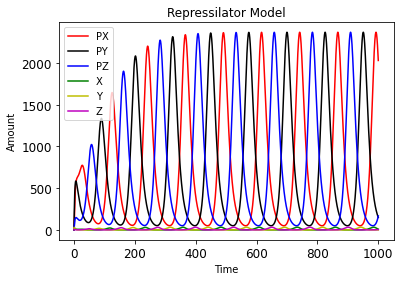

In [9]:
# Repressilator deterministic example
import bioscrape
plt.figure()
m = bioscrape.sbmlutil.import_sbml('models/repressilator_sbml.xml')
s = bioscrape.simulator.ModelCSimInterface(m)
s.py_prep_deterministic_simulation()
s.py_set_initial_time(0)

sim = bioscrape.simulator.DeterministicSimulator()
timepoints = np.linspace(0,1000,10000)
result = sim.py_simulate(s,timepoints)

plt.plot(timepoints,result.py_get_result())
plt.legend(m.get_species_list())
plt.title('Repressilator Model')
plt.xlabel('Time')
plt.ylabel('Amount')

The plot above should show deterministic oscillations. If we want to switch to stochastic simulation, all we need to do is switch the type of simulator we are using to the stochastic simulator. This can be done with the single following line.

In [10]:
sim = bioscrape.simulator.SSASimulator()

Now, we can run exactly the same code as above to generate a stochastic simulation trace.

Text(0, 0.5, 'Amount')

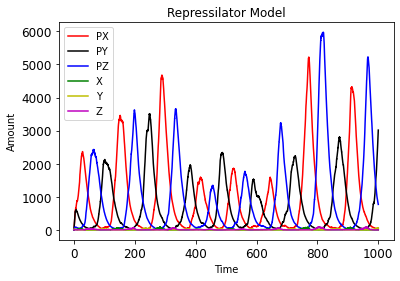

In [11]:
s.py_set_initial_time(0)
timepoints = np.linspace(0,1000,10000)
result = sim.py_simulate(s,timepoints)

plt.plot(timepoints,result.py_get_result())
plt.legend(m.get_species_list())
plt.title('Repressilator Model')
plt.xlabel('Time')
plt.ylabel('Amount')


Note that now the oscillations are non regular and stochastic.